<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/4_VGG%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9D%B4%EC%A0%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gender Classification Data**

In [ ]:
# url로 이미지가 연결된 남녀 사진자료임 !!
import pandas as pd 
from skimage import io   # 이미지 read
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense, Dropout
from tensorflow.keras.models import Sequential

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/gender_data.csv')  
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [ ]:
data.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at',
       'please_select_the_gender_of_the_person_in_the_picture',
       'please_select_the_gender_of_the_person_in_the_picture:confidence',
       'image_url',
       'please_select_the_gender_of_the_person_in_the_picture_gold',
       'user_id'],
      dtype='object')

In [ ]:
data.shape

(64084, 10)

In [ ]:
# 남녀 동등하게 1000개만 뽑아서 학습
final_data.shape
data_male=data[data['please_select_the_gender_of_the_person_in_the_picture']=='male']
data_female=data[data['please_select_the_gender_of_the_person_in_the_picture']=='female']
final_data=pd.concat([data_male[:1000],data_female[:1000]], axis=0).reset_index(drop=True) 

(2000, 10)

In [ ]:
# 이미지 load(url로 연결되어있음)
x=[]
y=[]
for i in range(final_data.shape[0]):
    try:
        image=io.imread(final_data.loc[i]['image_url'])
        if (image.shape==(300,300,3)): 
            x.append(image)
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
    except:
        continue

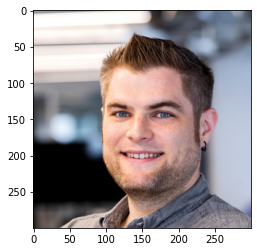

In [ ]:
plt.imshow(x[444])
plt.show()  # 300*300 사이즈로 이루어진 사진

확실히 300*300이라 매우 선명하다! 그만큼 픽셀이 많아서~~

In [ ]:
x[0].shape  # (300, 3)인 이미지가 300개 있는 상황!

(300, 300, 3)

In [ ]:
# Resize
x2=[]
y2=[]
for i in range(len(x)):  # 1760개의 data
    img2=cv2.resize(x[i],(50,50))   # cv로 50,50으로 resize, 채널은 3이 디폴트
    x2.append(img2)
    img_label=np.where(y[i]=='male',1,0)  # 남성이면 1, 아니면 0으로 one-hot으로 바꿔줌
    y2.append(img_label)

In [ ]:
x2[0].shape

(50, 50, 3)

In [ ]:
# 텐서(array 형태)로 변환
x2=np.array(x2)  # tensor에서 numpy data로 고쳐줌
x1=x2.astype('float32')/255.
y1=np.array(y2)
print(x1.shape, y1.shape)  # train, test data

(1730, 50, 50, 3) (1730,)


In [ ]:
# split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.1,random_state=1, stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1557, 50, 50, 3) (173, 50, 50, 3) (1557,) (173,)


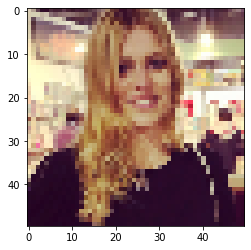

In [ ]:
plt.imshow(x_train[27])
plt.show()  # 50*50 사이즈의 RGB(채널 3)로 이루어진 사진

확실히 50*50으로 resize를 하면서 타일도 커지고 덜 선명해졌다(픽셀이 작아서)

# 1. Simple CNN

In [ ]:
# 픽셀이 점점 줄어드는 대신 채널의 수를 늘려서 특성을 효율적으로 추출하도록 한다
model=Sequential()                                     
model.add(Conv2D(32,(3,3),activation='relu',input_shape=[50,50,3]))  
model.add(MaxPooling2D((2,2))) 
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))  
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))  
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Flatten())
#### 통계모형의 형태 (logistic regression) ###### 
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이항분류이므로 sigmoid 출력
# 여기 regularization이 들어가는게 통계적으로 맞다
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         2

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
result=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))
score=model.evaluate(x_test,y_test)  # 모수가 100개이기 때문에 보나마나 오버피팅
print(score)

Epoch 1/10
49/49 [==============================] - 1s 10ms/step - loss: 0.6883 - acc: 0.5454 - val_loss: 0.6705 - val_acc: 0.6012
Epoch 2/10
49/49 [==============================] - 0s 5ms/step - loss: 0.6353 - acc: 0.6396 - val_loss: 0.6415 - val_acc: 0.6243
Epoch 3/10
49/49 [==============================] - 0s 5ms/step - loss: 0.5417 - acc: 0.7125 - val_loss: 0.5598 - val_acc: 0.7110
Epoch 4/10
49/49 [==============================] - 0s 5ms/step - loss: 0.4945 - acc: 0.7443 - val_loss: 0.6001 - val_acc: 0.6705
Epoch 5/10
49/49 [==============================] - 0s 5ms/step - loss: 0.4044 - acc: 0.8070 - val_loss: 0.5378 - val_acc: 0.7110
Epoch 6/10
49/49 [==============================] - 0s 5ms/step - loss: 0.3450 - acc: 0.8428 - val_loss: 0.5521 - val_acc: 0.7399
Epoch 7/10
49/49 [==============================] - 0s 5ms/step - loss: 0.2771 - acc: 0.8876 - val_loss: 0.6020 - val_acc: 0.7052
Epoch 8/10
49/49 [==============================] - 0s 5ms/step - loss: 0.2271 - acc: 0.9

데이터가 1700여개인데 마지막 dense층의 모수는 100개이니, 당연히 overfitting이 발생하였다. 

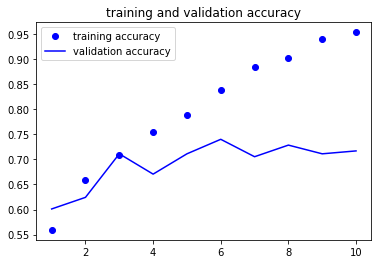

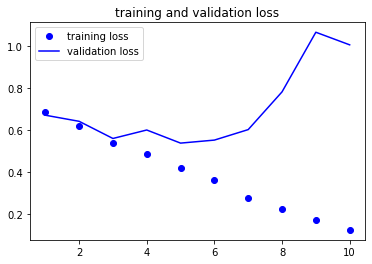

In [ ]:
acc=result.history['acc']
val_acc=result.history['val_acc']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## Visualization

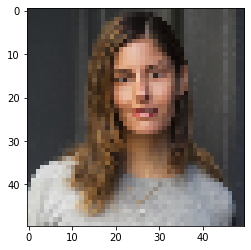

In [ ]:
plt.imshow(x_test[14])
plt.show()

In [ ]:
pic = np.expand_dims(x_test[14], axis=0)

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]  # 상위 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # 입력에 대한 8개 층의 출력을 반환하는 모델
activations = activation_model.predict(pic)   # Conv 층의 activation값 출력

In [ ]:
activations[0].shape   # 첫번째 Conv 층은 48*48크기를 가진 채널 32개의 feature map  

(1, 48, 48, 32)

첫번째 층 중에서 20번째 채널을 나타낸다. 머리카락의 엣지를 감지하고있다!

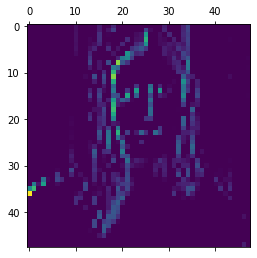

In [ ]:
first = activations[3]
plt.matshow(first[0, :, :, 19], cmap='viridis')   # 첫번째 층 중에서 20번째 채널 !! 

확실히 깊이가 깊어질수록 고수준의 특성을 학습한다. 점점 형태가 추상적으로 변한다!!

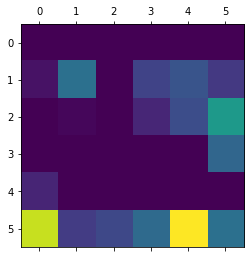

In [ ]:
first = activations[6]
plt.matshow(first[0, :, :, 10], cmap='viridis')  

# 2. 이전학습
> VGG16


#### 1) 모든 Conv층을 이용하고, MLP층과 출력층은 새롭게 학습

In [ ]:
# Pretrained VGG16
from tensorflow.keras.applications import VGG16  
vgg16_model=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))  # input size는 내 마음대로 조절 
vgg16_model.summary()  

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

Pretrained 된 VGG에게 기존의 남녀 데이터를 넣어서 예측하게한다!

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tqdm.notebook import tqdm

x5_vgg16=[]  # vgg가 predict한 값 저장
y5=[]

for i in tqdm(range(len(x))):
    img=x[i]
    img=preprocess_input(img.reshape(1,300,300,3))  # reshape : 맨 앞에 1을 집어 넣음 > 4d 텐서 전환
    img_new=vgg16_model.predict(img)  # vgg가 앞선 input을 학습하도록 함
    x5_vgg16.append(img_new) 
    img_label=np.where(y[i]=='male',1,0)
    y5.append(img_label)

In [ ]:
x5_vgg16[0].shape   # vgg의 하나의 predict값의 shape : vgg의 출력 shape과 같음!1 

(1, 9, 9, 512)

In [ ]:
# reshape
x5_vgg16=np.array(x5_vgg16)
print(x5_vgg16.shape)  # 불필요한 1이 존재하는 모습이다
x5_vgg16=x5_vgg16.reshape(x5_vgg16.shape[0],x5_vgg16.shape[2],x5_vgg16.shape[3],x5_vgg16.shape[4])  # reshape
y5=np.array(y5)  ## 이거 대신 tf.squeeze를 써도됨

(1730, 1, 9, 9, 512)


In [ ]:
print(x5_vgg16.shape)

(1730, 9, 9, 512)


VGG에서 나온 출력값을 X로 하고, true label을 y로 하여 한번 더 split한다

In [ ]:
# split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x5_vgg16,y5,test_size=0.1,random_state=1, stratify=y5)
## vgg 출력값이 X, label은 y
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1557, 9, 9, 512) (1557,) (173, 9, 9, 512) (173,)


이제 MLP부분과 출력층 부분만 모델링으로 쌓아주자!

In [ ]:
modelvgg16=Sequential()
modelvgg16.add(Conv2D(512,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
# VGG 마지막 채널 수 512 맞춰주기
modelvgg16.add(MaxPooling2D((2,2)))

# MLP 층
modelvgg16.add(Flatten())
modelvgg16.add(Dense(512,activation='relu'))
modelvgg16.add(Dropout(0.5))   # dropout 추가
modelvgg16.add(Dense(1,activation='sigmoid'))
modelvgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
____________________________________________

In [ ]:
modelvgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_vgg16=modelvgg16.fit(x_train/np.max(x_train), y_train,batch_size=32, epochs=20, validation_data=(x_test/np.max(x_train),y_test))

Epoch 1/20
49/49 [==============================] - 1s 10ms/step - loss: 0.5130 - accuracy: 0.7492 - val_loss: 0.2811 - val_accuracy: 0.8902
Epoch 2/20
49/49 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.9451 - val_loss: 0.1954 - val_accuracy: 0.9364
Epoch 3/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.9786 - val_loss: 0.2203 - val_accuracy: 0.9364
Epoch 4/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.2508 - val_accuracy: 0.9306
Epoch 5/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.3271 - val_accuracy: 0.9191
Epoch 6/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3381 - val_accuracy: 0.9249
Epoch 7/20
49/49 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.9249
Epoch 8/20
49/49 [=

정확도가 93정도로 매우매우 높아진 것을 확인할 수 있지만, 아직도 오버피팅은 존재한다

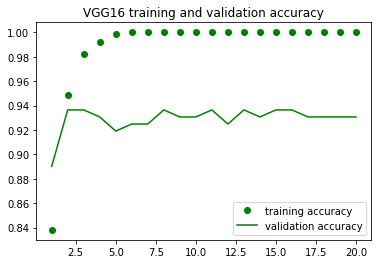

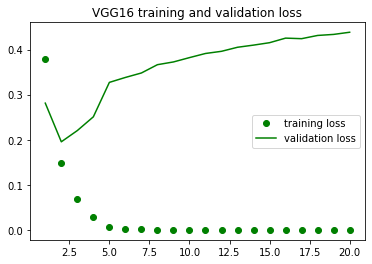

In [ ]:
import matplotlib.pyplot as plt
acc=history_vgg16.history['accuracy']
val_acc=history_vgg16.history['val_accuracy']
loss=history_vgg16.history['loss']
val_loss=history_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'go',label='training accuracy')
plt.plot(epochs, val_acc,'g',label='validation accuracy')
plt.title('VGG16 training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'go',label='training loss')
plt.plot(epochs, val_loss,'g',label='validation loss')
plt.title('VGG16 training and validation loss')
plt.legend()
plt.show()

In [ ]:
pic = np.expand_dims(x_test[14], axis=0)

In [ ]:
layer_outputs = [layer.output for layer in modelvgg16.layers[:8]]  # 상위 8개 층의 출력을 추출
activation_model = models.Model(inputs=modelvgg16.input, outputs=layer_outputs)  # 입력에 대한 8개 층의 출력을 반환하는 모델
activations = activation_model.predict(pic)   # Conv 층의 activation값 출력

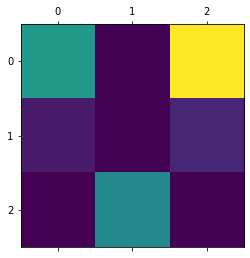

In [ ]:
first = activations[1]
plt.matshow(first[0, :, :, 19], cmap='viridis')   # 첫번째 층 중에서 20번째 채널 !! 

이미 고수준 특성을 학습하고 있음을 알 수 있다!